<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Mon Jul 29 19:14:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:A8:00.0 Off |                    0 |
| N/A   35C    P0             77W /  350W |    4591MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
import multiprocessing
from multiprocessing import Pool, cpu_count
import os
import psutil

###### Parameters 
mag = 1            # Magnitude of the coupling
beta = 1           # Inverse temperature 
alpha = 1            
gamma = 1          # Anharmonic potential U(x) = alpha/2 * x^2 + gamma/4 * x^4
N = 100            # Total number of oscillators in the chain 
dt = 0.01 
delta_t = 0.5
batch = 800
minibatch = 1
sec_length = 400

Time = 5 * delta_t * sec_length
length = int(Time / dt) + 1
t = np.linspace(0, Time, length) # Define time axis
gap = int(delta_t / dt)
t_store = t[0:-1:gap]

# (q25,q75)
q25_store = np.zeros([t_store.size + 1, batch])    
q75_store = np.zeros([t_store.size + 1, batch])

In [8]:
def solve_sde(batch_idx):
    np.random.seed((batch_idx+1)*100)
    name = multiprocessing.current_process().name        
    print(f'>>>>>>>===============================================\n{name} starting. \nparent process:{os.getppid()}------process id:{os.getpid()}\n===============================================>>>>>>>\n')    
    
    p0 = np.zeros((N, minibatch))
    q0 = np.zeros((N, minibatch))
    p1 = np.zeros((N, minibatch))
    q1 = np.zeros((N, minibatch))

    local_q25_store = np.zeros([t_store.size + 1, minibatch])    
    local_q75_store = np.zeros([t_store.size + 1, minibatch])

    j = 1
    for i in range(1, length):
        q1 = q0 + dt * (p0 - np.roll(p0, 1, axis=0))
        p1 = (1 - mag * dt) * p0 + dt * alpha * (np.roll(q0, -1, axis=0) - q0) + \
             dt * gamma * (np.roll(q0, -1, axis=0)**3 - q0**3) + \
             np.sqrt(2 * dt * gamma / beta) * np.random.randn(N, minibatch)
        if i % gap == 0:
            local_q25_store[j,:] = np.sum(q1[0:25,:], axis=0)
            local_q75_store[j,:] = np.sum(q1[0:75,:], axis=0)
            j += 1
        p0 = p1
        q0 = q1
    
    print(f"Batch {batch_idx} completed. \n")
    return batch_idx, local_q25_store, local_q75_store

In [9]:
if __name__ == '__main__':
    start = time.time()
    test_batch = int(batch / minibatch)
    num_cores = min(cpu_count(), test_batch)
    with Pool(num_cores) as pool:
        results = pool.map(solve_sde, range(test_batch))
    pool.close()
    pool.join()
    
    end = time.time()
    
    print(f'total runtime: {end-start}')

>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1371876------process id:1372032
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1371876------process id:1372036
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-59 starting. 
parent process:1371876------process id:1372033
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1371876------process id:1372030
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1371876------process id:1372029
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-

>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1371876------process id:1371987
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1371876------process id:1371990
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1371876------process id:1371989
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1371876------process id:1371994
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1371876------process id:1371985
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-


>>>>>>>===============================================
ForkPoolWorker-43 starting. 
parent process:1371876------process id:1372017
===============================================>>>>>>>

Batch 44 completed. 


>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1371876------process id:1372031
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1371876------process id:1372008
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-33 starting. 
parent process:1371876------process id:1372007
===============================================>>>>>>>
Batch 216 completed. 

Batch 188 completed. 






Batch 8 completed. 

>>>>>>>===============================================
ForkPoolWorker-38 starting. 
parent process:1371876------process id:1372012
============================

>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:1371876------process id:1371991
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1371876------process id:1371979
===============================================>>>>>>>




Batch 181 completed. 

Batch 113 completed. 
Batch 41 completed. 
>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1371876------process id:1372020
===============================================>>>>>>>


Batch 77 completed. 
Batch 209 completed. 
Batch 5 completed. 

Batch 169 completed. 
>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:1371876------process id:1372003
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:

Batch 21 completed. 


>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1371876------process id:1372002
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1371876------process id:1371986
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-36 starting. 
parent process:1371876------process id:1372010
===============================================>>>>>>>
Batch 197 completed. 
Batch 189 completed. 
>>>>>>>===============================================
ForkPoolWorker-64 starting. 
parent process:1371876------process id:1372038
===============================================>>>>>>>




>>>>>>>===============================================
ForkPoolWorker-51 starting. 
parent process:1371876------process id:1372025
===============================================>>>>>>>

Batch 206 completed. 
>>>>>>>===============================================
ForkPoolWorker-45 starting. 
parent process:1371876------process id:1372019
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1371876------process id:1371975
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-21 starting. 
parent process:1371876------process id:1371995
===============================================>>>>>>>
Batch 186 completed. 
>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1371876------process id:1372016
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-10 starting. 
parent process:1371876------process id:1371984
===============================================>>>>>>>

>>>>>>>================

>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1371876------process id:1372013
===============================================>>>>>>>

Batch 30 completed. 
Batch 126 completed. 
>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1371876------process id:1372030
===============================================>>>>>>>




Batch 62 completed. 

Batch 246 completed. 
Batch 122 completed. 
>>>>>>>===============================================
ForkPoolWorker-8 starting. 
parent process:1371876------process id:1371982
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-32 starting. 
parent process:1371876------process id:1372006
===============================================>>>>>>>

Batch 230 completed. 




>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1371876------proc



>>>>>>>===============================================
ForkPoolWorker-26 starting. 
parent process:1371876------process id:1372000
===============================================>>>>>>>

Batch 47 completed. 
>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1371876------process id:1371978
===============================================>>>>>>>


Batch 151 completed. 





>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1371876------process id:1372004
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1371876------process id:1372031
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1371876------process id:1372037
===============================================>>>>>>>


Batch 255 comp



>>>>>>>===============================================
ForkPoolWorker-53 starting. 
parent process:1371876------process id:1372027
===============================================>>>>>>>


Batch 272 completed. 
>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1371876------process id:1371976
===============================================>>>>>>>
Batch 280 completed. 



Batch 288 completed. 

Batch 312 completed. 
Batch 276 completed. 
>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1371876------process id:1371994
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:1371876------process id:1372023
===============================================>>>>>>>
Batch 304 completed. 



>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1371876------p

>>>>>>>===============================================
ForkPoolWorker-54 starting. 
parent process:1371876------process id:1372028
===============================================>>>>>>>
Batch 428 completed. 


Batch 448 completed. 



Batch 440 completed. 




>>>>>>>===============================================
ForkPoolWorker-6 starting. 
parent process:1371876------process id:1371980
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-28 starting. 
parent process:1371876------process id:1372002
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1371876------process id:1372009
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-48 starting. 
parent process:1371876------process id:1372022
===============================================>>>

>>>>>>>===============================================
ForkPoolWorker-60 starting. 
parent process:1371876------process id:1372034
===============================================>>>>>>>

Batch 341 completed. 

Batch 353 completed. 



Batch 357 completed. 



Batch 301 completed. 


Batch 389 completed. 
>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1371876------process id:1371999
===============================================>>>>>>>
Batch 373 completed. 

>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1371876------process id:1371997
===============================================>>>>>>>
Batch 365 completed. 
>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1371876------process id:1372004
===============================================>>>>>>>
Batch 381 completed. 

>>>>>>>===============================================
ForkPoolWorke


>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1371876------process id:1372005
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1371876------process id:1372032
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-17 starting. 
parent process:1371876------process id:1371991
===============================================>>>>>>>

Batch 493 completed. 


Batch 501 completed. 
>>>>>>>===============================================
ForkPoolWorker-16 starting. 
parent process:1371876------process id:1371990
===============================================>>>>>>>


>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1371876------process id:1371987
===============================================>>>>>>>

Batch 509 comple



>>>>>>>===============================================
ForkPoolWorker-40 starting. 
parent process:1371876------process id:1372014
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-44 starting. 
parent process:1371876------process id:1372018
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1371876------process id:1371986
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-21 starting. 
parent process:1371876------process id:1371995
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1371876------process id:1372037
===============================================>>>>>>>


Batch 350 completed. 



>>>>>>>=================================



Batch 319 completed. 
>>>>>>>===============================================
ForkPoolWorker-20 starting. 
parent process:1371876------process id:1371994
===============================================>>>>>>>




>>>>>>>===============================================
ForkPoolWorker-18 starting. 
parent process:1371876------process id:1371992
===============================================>>>>>>>
Batch 311 completed. 
Batch 283 completed. 
Batch 347 completed. 
Batch 371 completed. 
>>>>>>>===============================================
ForkPoolWorker-42 starting. 
parent process:1371876------process id:1372016
===============================================>>>>>>>

Batch 375 completed. 






>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1371876------process id:1372008
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:1371876-----

>>>>>>>===============================================
ForkPoolWorker-35 starting. 
parent process:1371876------process id:1372009
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-50 starting. 
parent process:1371876------process id:1372024
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-15 starting. 
parent process:1371876------process id:1371989
===============================================>>>>>>>
Batch 475 completed. 
Batch 491 completed. 



Batch 459 completed. 
>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1371876------process id:1372030
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-62 starting. 
parent process:1371876------process id:1372036
===============================================>>>>>>

Batch 680 completed. 
Batch 640 completed. 


>>>>>>>===============================================
ForkPoolWorker-23 starting. 
parent process:1371876------process id:1371997
===============================================>>>>>>>
Batch 624 completed. 

Batch 644 completed. 
>>>>>>>===============================================
ForkPoolWorker-57 starting. 
parent process:1371876------process id:1372031
===============================================>>>>>>>
Batch 636 completed. 
>>>>>>>===============================================
ForkPoolWorker-22 starting. 
parent process:1371876------process id:1371996
===============================================>>>>>>>



>>>>>>>===============================================
ForkPoolWorker-55 starting. 
parent process:1371876------process id:1372029
===============================================>>>>>>>
>>>>>>>===============================================
ForkPoolWorker-25 starting. 
parent process:1371876------process id:1371999
=========

Batch 764 completed. 


>>>>>>>===============================================
ForkPoolWorker-13 starting. 
parent process:1371876------process id:1371987
===============================================>>>>>>>

Batch 513 completed. 

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1371876------process id:1371975
===============================================>>>>>>>

Batch 517 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1371876------process id:1371976
===============================================>>>>>>>

Batch 525 completed. 

>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1371876------process id:1372020
===============================================>>>>>>>

Batch 521 completed. 

Batch 533 completed. 
>>>>>>>===============================================
ForkPoolWorker-29 starting. 
parent process:1371876------proc


>>>>>>>===============================================
ForkPoolWorker-21 starting. 
parent process:1371876------process id:1371995
===============================================>>>>>>>

Batch 693 completed. 
>>>>>>>===============================================
ForkPoolWorker-19 starting. 
parent process:1371876------process id:1371993
===============================================>>>>>>>

Batch 665 completed. 

Batch 677 completed. 
>>>>>>>===============================================
ForkPoolWorker-63 starting. 
parent process:1371876------process id:1372037
===============================================>>>>>>>


Batch 649 completed. 



>>>>>>>===============================================
ForkPoolWorker-39 starting. 
parent process:1371876------process id:1372013
===============================================>>>>>>>
Batch 697 completed. 

>>>>>>>===============================================
ForkPoolWorker-12 starting. 
parent process:1371876------process id:1371986
=====


Batch 682 completed. 


>>>>>>>===============================================
ForkPoolWorker-34 starting. 
parent process:1371876------process id:1372008
===============================================>>>>>>>

Batch 566 completed. 

>>>>>>>===============================================
ForkPoolWorker-3 starting. 
parent process:1371876------process id:1371977
===============================================>>>>>>>
Batch 594 completed. 


Batch 590 completed. 

>>>>>>>===============================================
ForkPoolWorker-49 starting. 
parent process:1371876------process id:1372023
===============================================>>>>>>>

Batch 602 completed. 
>>>>>>>===============================================
ForkPoolWorker-30 starting. 
parent process:1371876------process id:1372004
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-37 starting. 
parent process:1371876------process id:1372011
======



Batch 726 completed. 

>>>>>>>===============================================
ForkPoolWorker-27 starting. 
parent process:1371876------process id:1372001
===============================================>>>>>>>
Batch 742 completed. 


>>>>>>>===============================================
ForkPoolWorker-31 starting. 
parent process:1371876------process id:1372005
===============================================>>>>>>>
Batch 718 completed. 
Batch 746 completed. 


Batch 758 completed. 

>>>>>>>===============================================
ForkPoolWorker-56 starting. 
parent process:1371876------process id:1372030
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-58 starting. 
parent process:1371876------process id:1372032
===============================================>>>>>>>

>>>>>>>===============================================
ForkPoolWorker-5 starting. 
parent process:1371876------process id:1371979
======



>>>>>>>===============================================
ForkPoolWorker-4 starting. 
parent process:1371876------process id:1371978
===============================================>>>>>>>

Batch 770 completed. 

>>>>>>>===============================================
ForkPoolWorker-1 starting. 
parent process:1371876------process id:1371975
===============================================>>>>>>>
Batch 782 completed. 


>>>>>>>===============================================
ForkPoolWorker-11 starting. 
parent process:1371876------process id:1371985
===============================================>>>>>>>

Batch 774 completed. 

>>>>>>>===============================================
ForkPoolWorker-2 starting. 
parent process:1371876------process id:1371976
===============================================>>>>>>>
Batch 778 completed. 
Batch 786 completed. 



>>>>>>>===============================================
ForkPoolWorker-46 starting. 
parent process:1371876------process id:1372020
=======

Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

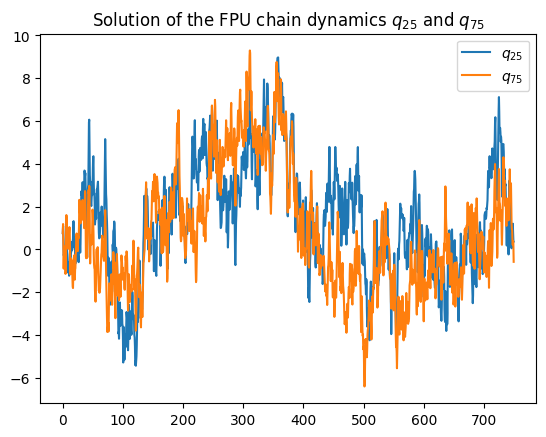

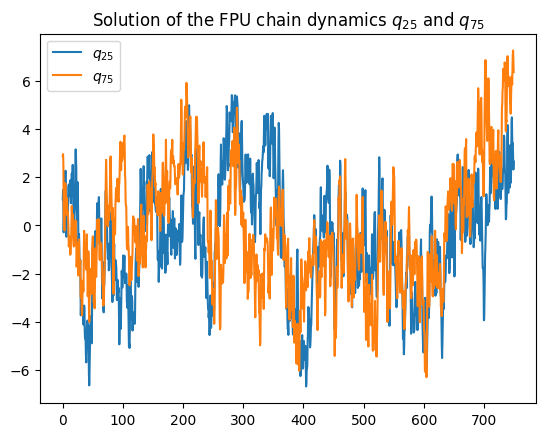

In [10]:
for i, local_q25_store, local_q75_store in results:
        q25_store[:, i*minibatch:(i+1)*minibatch] = local_q25_store
        q75_store[:, i*minibatch:(i+1)*minibatch] = local_q75_store

Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1], label=r"$q_{25}$")
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1], label=r"$q_{75}$")
plt.legend()
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 800) (400, 800) (400, 800)
(400, 800) (400, 800, 2)


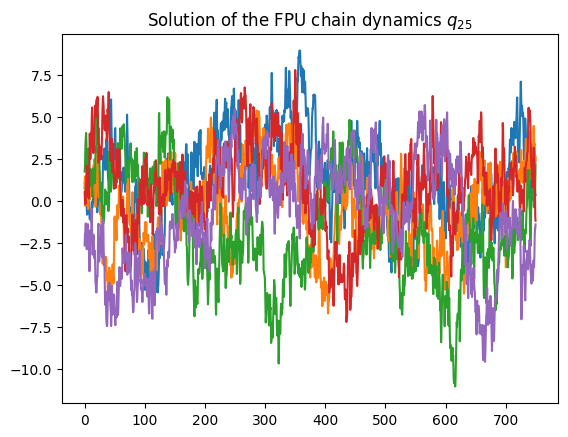

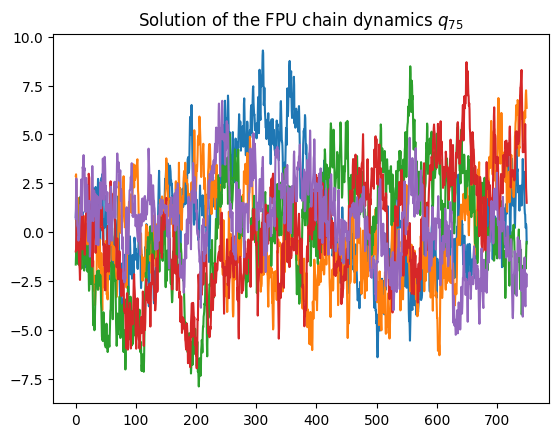

In [11]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [12]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [13]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 800, 2]) torch.float32
The torch validation size is torch.Size([800, 800, 2]) torch.float32
The torch target size is torch.Size([400, 800, 2]) torch.float32


In [14]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


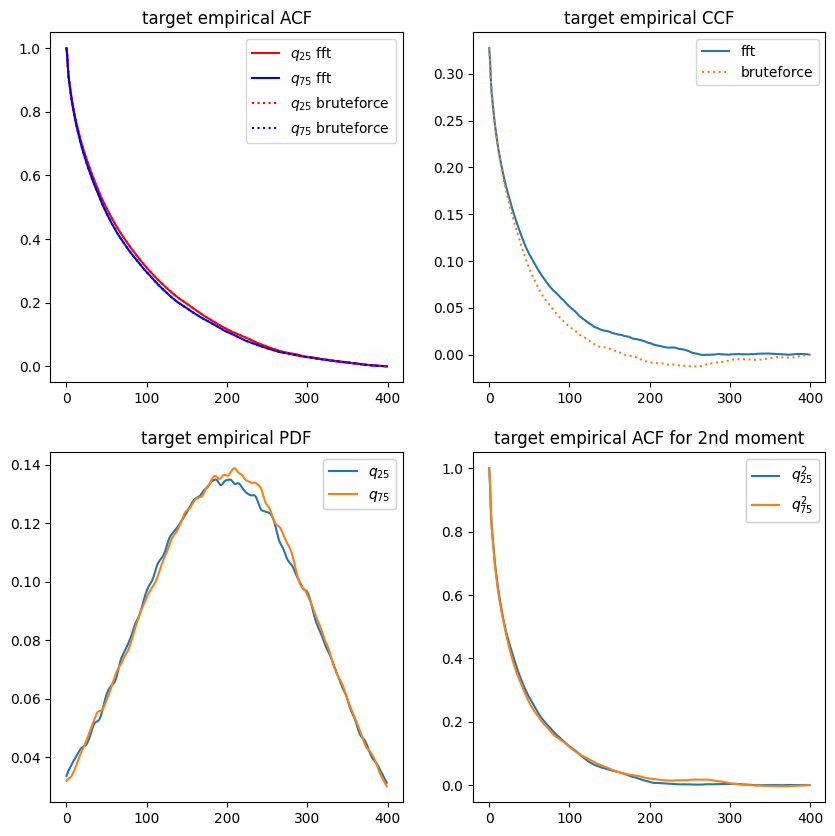

In [15]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

In [16]:
plt.rcParams.update({'font.size': 20})

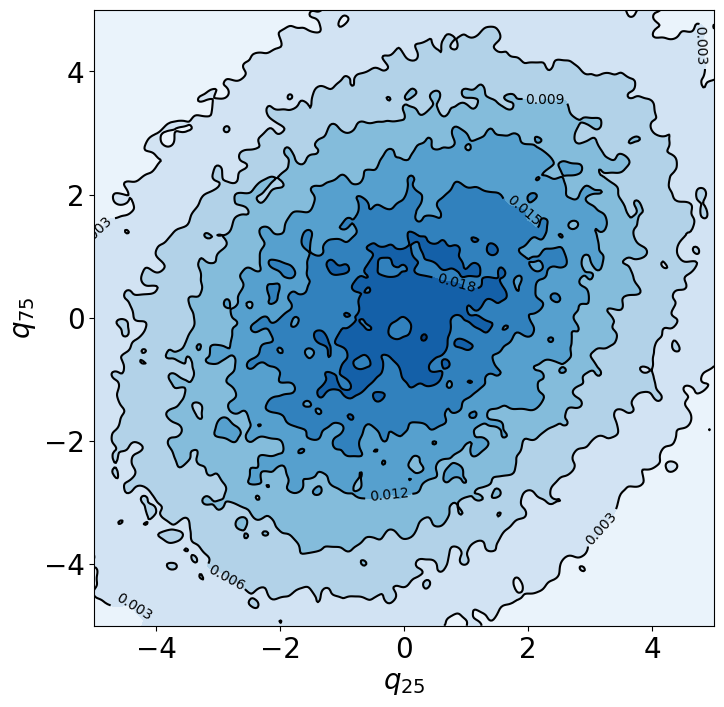

In [17]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

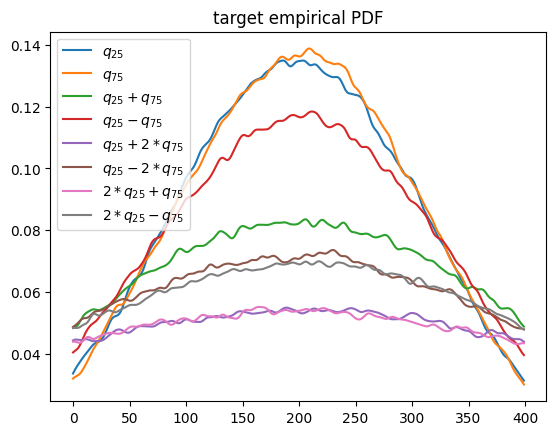

In [17]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [18]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2


    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(15000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
#             if acf <=0.0001 and ccf <=0.0001 and pdf<=0.00002 and pdf2<=0.00002 and acf_sec_moment<=0.0001:
#                 break

#         if acf > 0.0001 or ccf > 0.0001 or pdf >0.00002 or pdf2 >0.00002 or acf_sec_moment>0.0001:
#             print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <=0.0003 and loss_val <=0.0003:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
#         if acf > 0.0001 or ccf > 0.0001 or pdf >0.00002 or pdf2 >0.00002 or acf_sec_moment>0.0001:
#             print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)

In [23]:
### Defining SINN model
net = SINN(2, 200, 4, 2).to(device) # input dimension, hidden size, number of layers, output dimension

In [24]:
model = Model(net=net)

In [25]:
model_type = 1

In [26]:
model.train()

[0]-th step loss: 0.7899, 0.7825, acf: 0.07107, ccf: 0.00526, pdf: 0.33751, pdf2: 0.34440, acf2: 0.02426
[50]-th step loss: 0.0689, 0.0644, acf: 0.02286, ccf: 0.02289, pdf: 0.00473, pdf2: 0.00707, acf2: 0.00689
[100]-th step loss: 0.0509, 0.0520, acf: 0.02502, ccf: 0.01636, pdf: 0.00475, pdf2: 0.00497, acf2: 0.00086
[150]-th step loss: 0.0316, 0.0291, acf: 0.01378, ccf: 0.01261, pdf: 0.00096, pdf2: 0.00123, acf2: 0.00047
[200]-th step loss: 0.1293, 0.1182, acf: 0.05961, ccf: 0.00855, pdf: 0.02393, pdf2: 0.01010, acf2: 0.01601
[250]-th step loss: 0.0455, 0.0417, acf: 0.01409, ccf: 0.01891, pdf: 0.00447, pdf2: 0.00235, acf2: 0.00186
[300]-th step loss: 0.0174, 0.0181, acf: 0.00808, ccf: 0.00133, pdf: 0.00499, pdf2: 0.00213, acf2: 0.00158
[350]-th step loss: 0.0092, 0.0084, acf: 0.00137, ccf: 0.00082, pdf: 0.00346, pdf2: 0.00118, acf2: 0.00155
[400]-th step loss: 0.0293, 0.0300, acf: 0.01425, ccf: 0.00351, pdf: 0.00716, pdf2: 0.00418, acf2: 0.00094
[450]-th step loss: 0.0037, 0.0036, acf:

[3850]-th step loss: 0.0010, 0.0009, acf: 0.00004, ccf: 0.00063, pdf: 0.00009, pdf2: 0.00002, acf2: 0.00008
[3900]-th step loss: 0.0024, 0.0023, acf: 0.00148, ccf: 0.00010, pdf: 0.00030, pdf2: 0.00016, acf2: 0.00024
[3950]-th step loss: 0.0040, 0.0040, acf: 0.00077, ccf: 0.00271, pdf: 0.00020, pdf2: 0.00009, acf2: 0.00021
[4000]-th step loss: 0.0028, 0.0021, acf: 0.00073, ccf: 0.00064, pdf: 0.00037, pdf2: 0.00016, acf2: 0.00017
[4050]-th step loss: 0.0055, 0.0052, acf: 0.00192, ccf: 0.00079, pdf: 0.00150, pdf2: 0.00057, acf2: 0.00040
[4100]-th step loss: 0.0007, 0.0009, acf: 0.00008, ccf: 0.00033, pdf: 0.00029, pdf2: 0.00009, acf2: 0.00013
[4150]-th step loss: 0.0014, 0.0007, acf: 0.00010, ccf: 0.00023, pdf: 0.00012, pdf2: 0.00018, acf2: 0.00010
[4200]-th step loss: 0.0125, 0.0112, acf: 0.00092, ccf: 0.00078, pdf: 0.00313, pdf2: 0.00235, acf2: 0.00403
[4250]-th step loss: 0.0022, 0.0019, acf: 0.00050, ccf: 0.00026, pdf: 0.00046, pdf2: 0.00025, acf2: 0.00046
[4300]-th step loss: 0.0010,

In [27]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Iteration $n$',fontsize=15)
    plt.ylabel(r'$l_2 loss$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [28]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Iteration $n$',fontsize=15)
    plt.ylabel(r'$l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [29]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [30]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

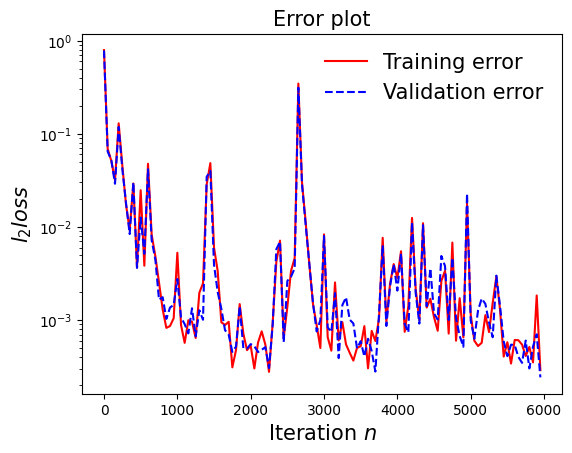

In [31]:
draw_loss(model)

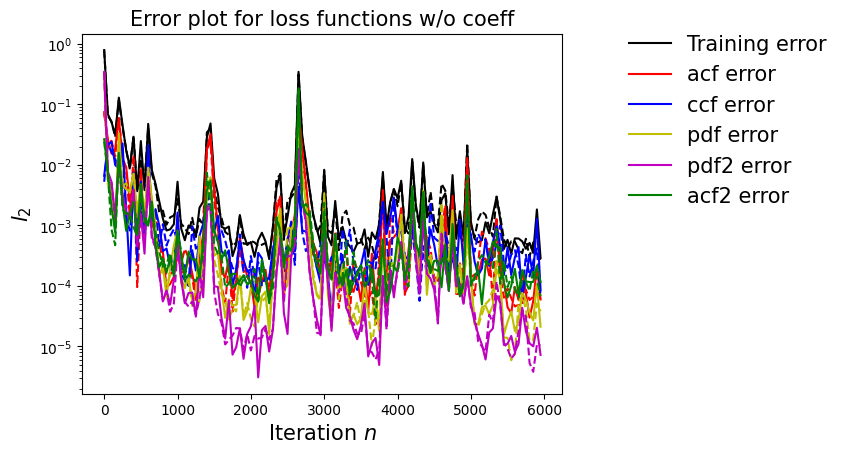

In [32]:
draw_errors(model)

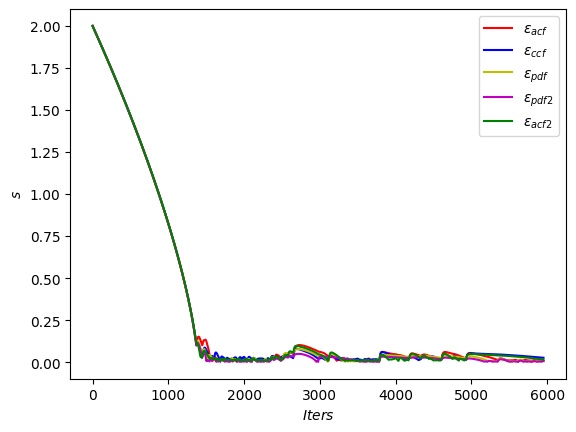

In [33]:
draw_adaptive_w(model)

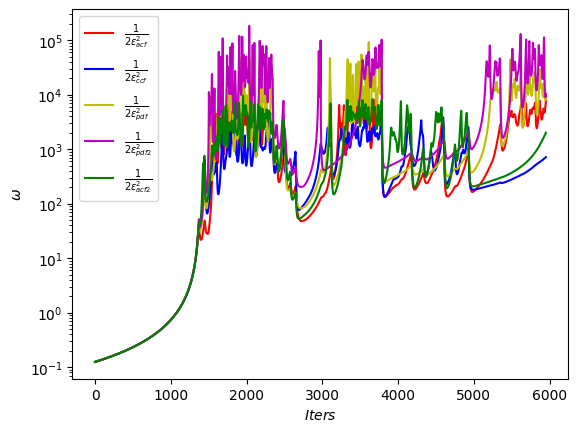

In [34]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [35]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [36]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [37]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{49}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{49}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{50}$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{49}+q_{50}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{49}-q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{49}+q_{50}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{49}-q_{50}$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{49}+2q_{50}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{49}-2q_{50}$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{49}+2\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{49}-2\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{49}+\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{49}-\tilde{q}_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{49}+\tilde{q}_2$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{49}-\tilde{q}_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [38]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{49}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{50}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [39]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [40]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [41]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

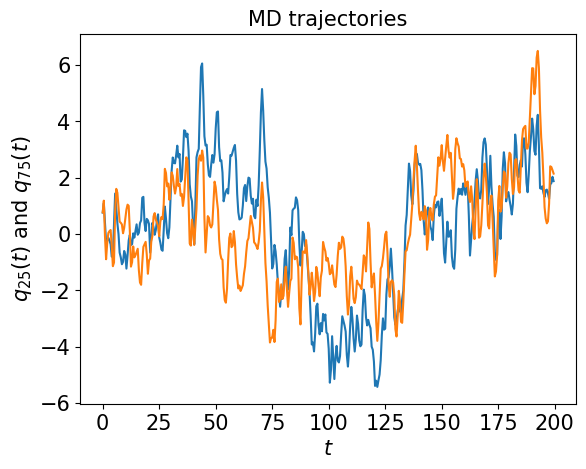

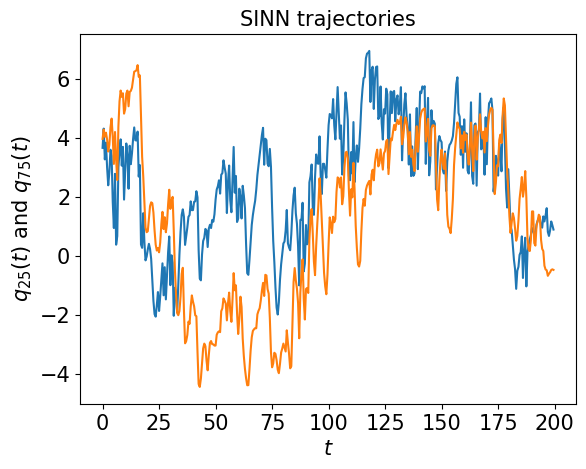

In [42]:
test1(model)

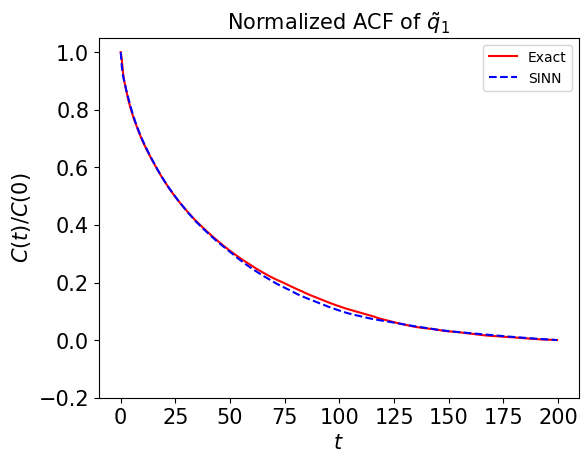

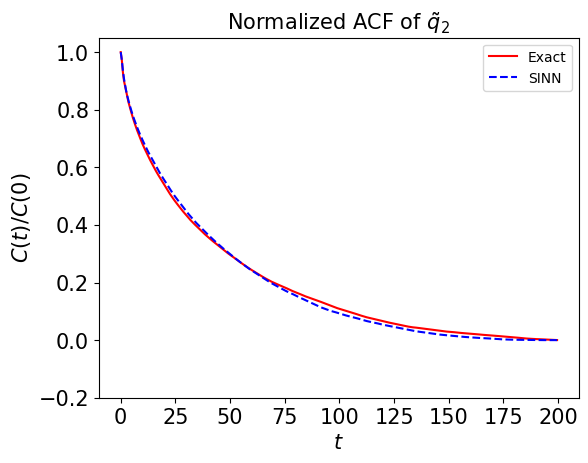

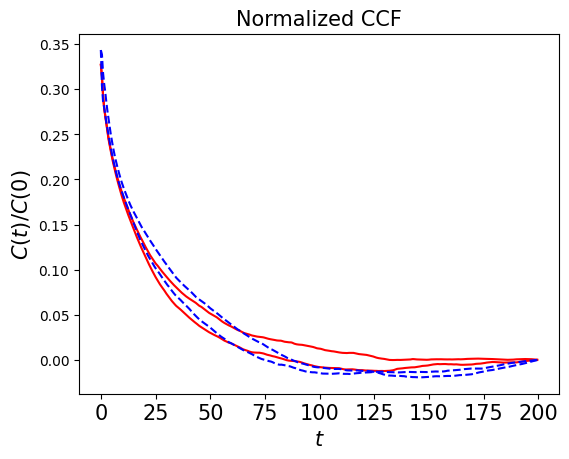

In [43]:
test2(model)

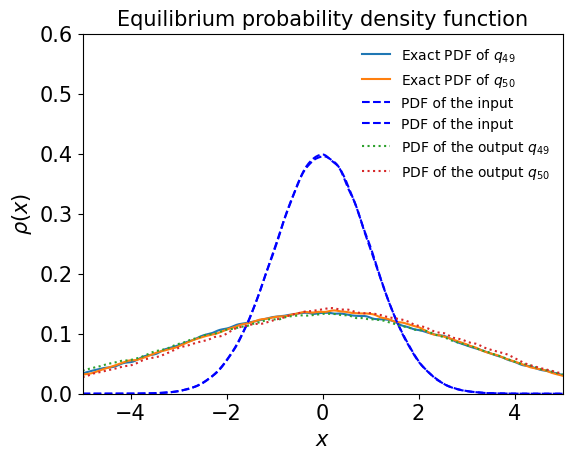

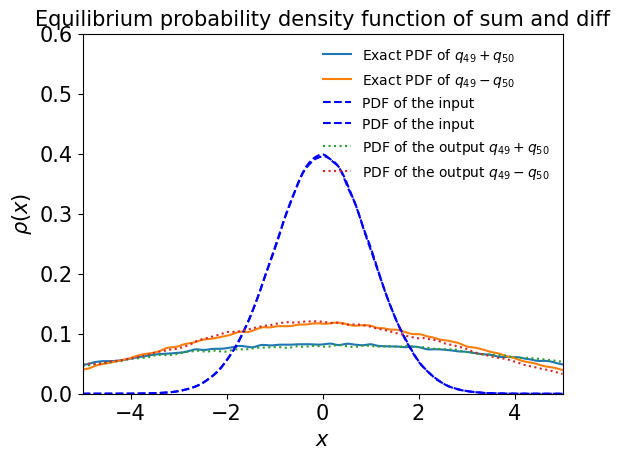

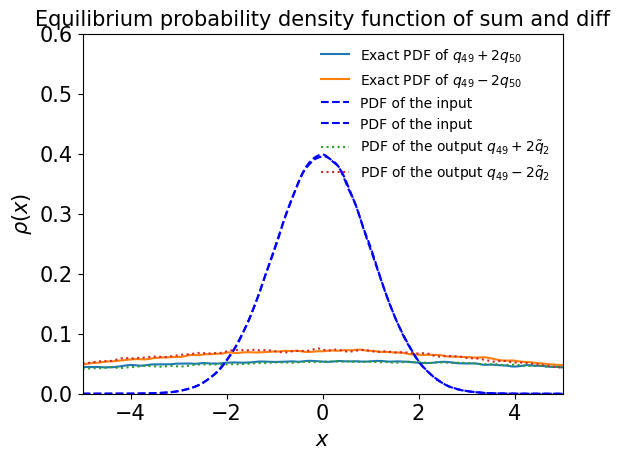

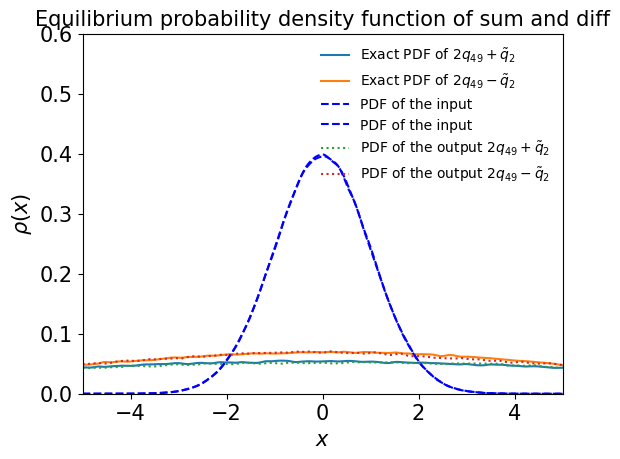

In [44]:
test3(model)

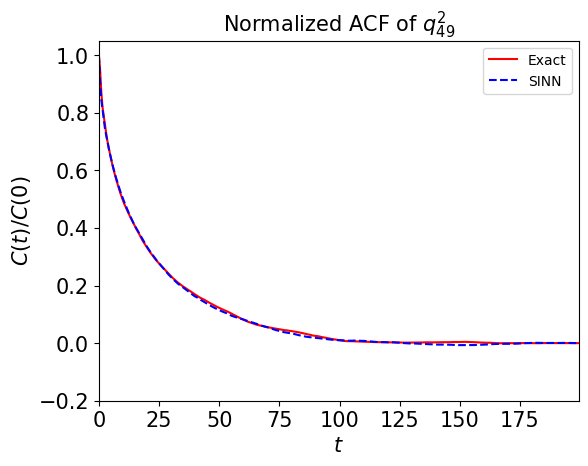

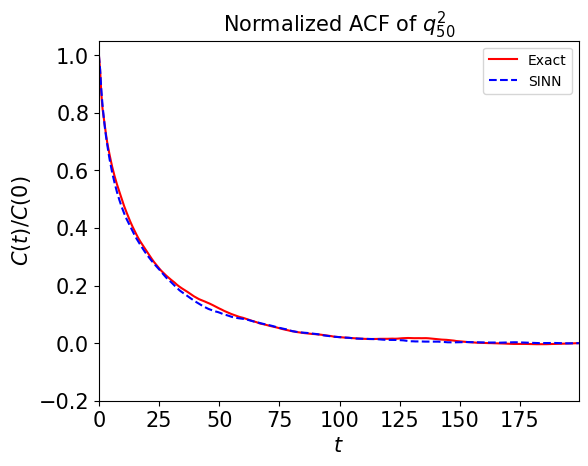

In [45]:
test4(model)

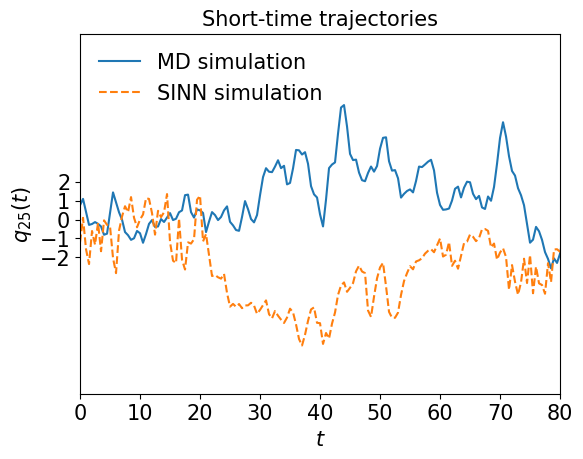

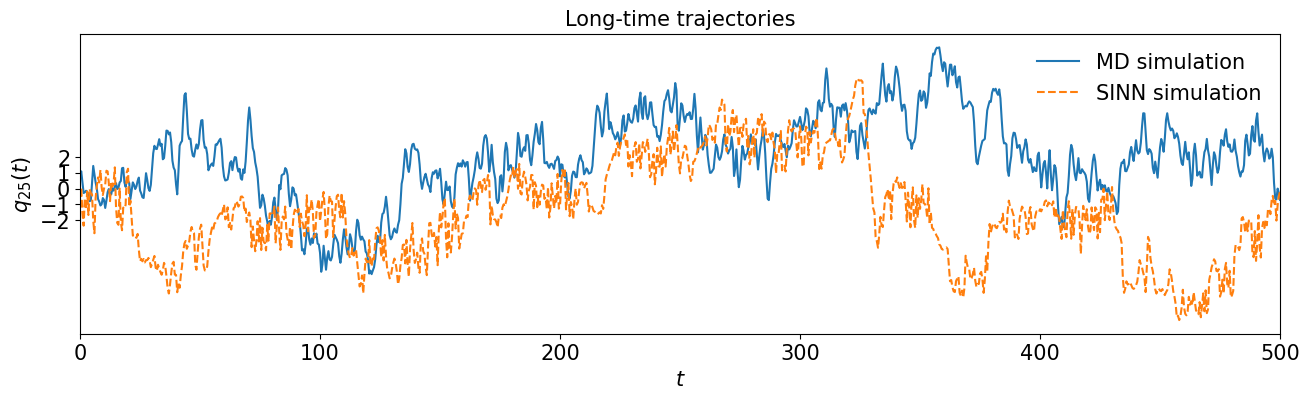

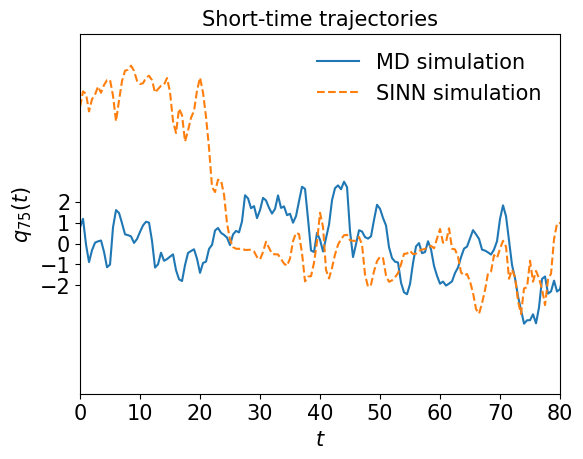

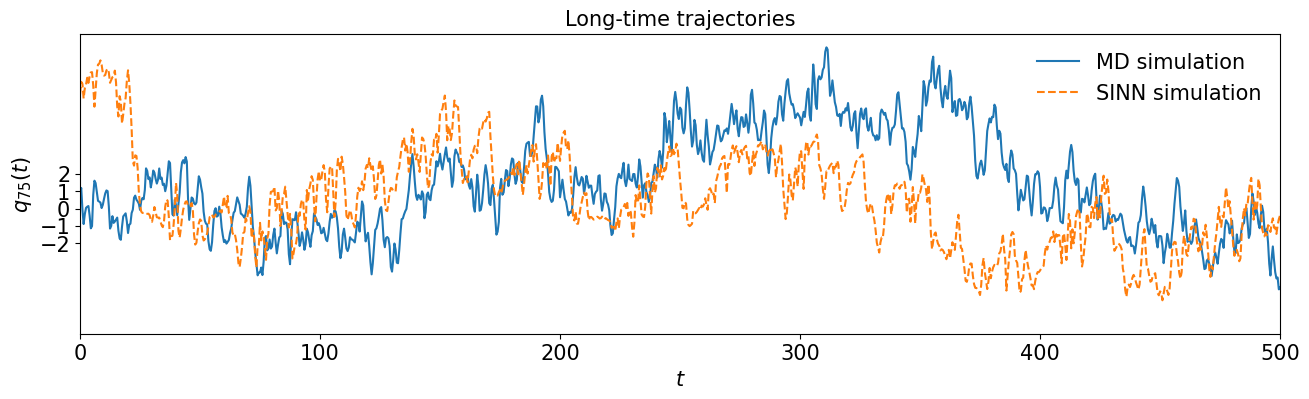

In [46]:
test5(model)

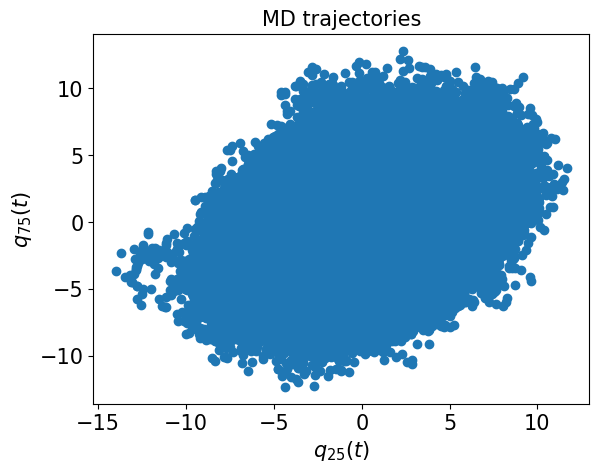

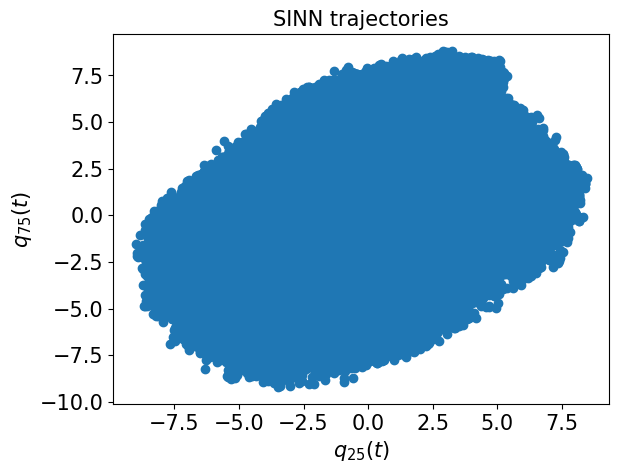

In [47]:
test6(model)

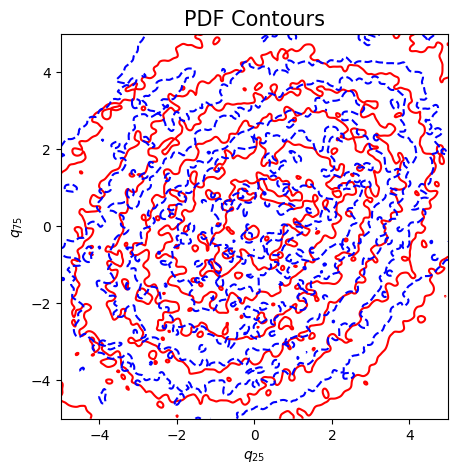

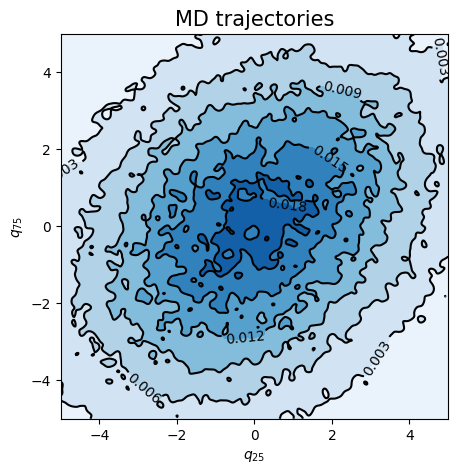

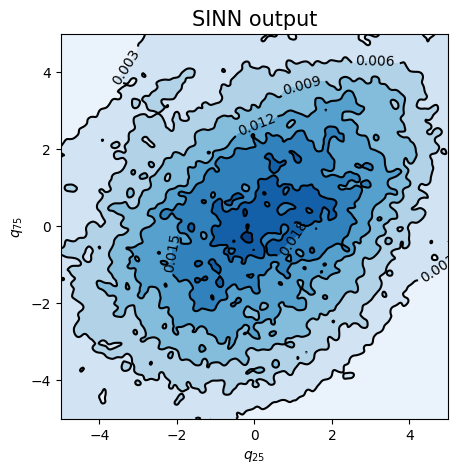

In [48]:
test7(model)